In [ ]:
#Wilma Ellaine Manzano
#301181591

1) Import all the necessary libraries, read the dataset using pandas and analyze the data. For data preparation phase, save the “benign” and “attack” dataframe separately. Drop the “Label” column from the dataset and convert benign and attack dataframes to numpy arrays. Now, split the data into test and train (use 75% observations for train set and the remaining 25% for test set). Then, scale the train and test data using Standard Scalar. [10% marks].

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow import keras
from numpy.random import seed
seed(1)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [ ]:
data = pd.read_csv('network_attack_data.csv')
data.head()

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,...,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,Label
0,109998919,4,3,525,0.0,520,0,131.25,259.177385,0,...,32,5735.0,0.0,5735.0,5735.0,110000000.0,0.0,110000000.0,110000000.0,1
1,109993343,4,3,531,0.0,520,0,132.75,258.218738,0,...,32,5437.0,0.0,5437.0,5437.0,110000000.0,0.0,110000000.0,110000000.0,1
2,109988359,4,3,535,0.0,520,0,133.75,257.597069,0,...,32,5505.0,0.0,5505.0,5505.0,110000000.0,0.0,110000000.0,110000000.0,1
3,109982960,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5303.0,0.0,5303.0,5303.0,110000000.0,0.0,110000000.0,110000000.0,1
4,109977744,4,3,530,0.0,520,0,132.50,258.376341,0,...,32,5356.0,0.0,5356.0,5356.0,110000000.0,0.0,110000000.0,110000000.0,1


In [ ]:
data['Label'].value_counts()

0    22987
1     5498
Name: Label, dtype: int64

In [ ]:
benign = data['Label']== 0 # create a dataframe for benign data
attack = data['Label']== 1  # create dataframe for attack data

data_benign = data[benign]
data_attack = data[attack]

print(f"Benign count: {len(data_benign)}")
print(f"Attack count: {len(data_attack)}")

Benign count: 22987
Attack count: 5498


In [ ]:
# convert dataframes to numpy arrays after dropping the label (Label 0/1)
x_benign = data_benign.drop('Label',axis=1).values 
y_benign = data_benign['Label'].values

x_attack = data_attack.drop('Label',axis=1).values 
y_attack = data_attack['Label'].values

print(x_benign.shape, x_attack.shape)
print(y_benign.shape, y_attack.shape)

(22987, 76) (5498, 76)
(22987,) (5498,)


In [ ]:
#train-test split for benign train and test data
from sklearn.model_selection import train_test_split
x_benign_train, x_benign_test = train_test_split(x_benign, test_size=0.25, random_state=40)
print(x_benign_train.shape, x_benign_test.shape)

(17240, 76) (5747, 76)


In [ ]:
import joblib
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_ben_tr_scaled= scaler.fit_transform(x_benign_train) # fit_transform on train data
x_ben_tst_scaled= scaler.transform(x_benign_test) # transform on test data
x_attack_scaled= scaler.transform(x_attack) # transform on test data

2) Set the following hyperparameter values: [5% marks].
 • batch_size = 32
• original_dim = 76
• latent_dim = 10
• number of neurons in the hidden layers = 50
• epochs = 100

In [ ]:
batch_size = 32
original_dim = 76 ## number of features
latent_dim = 10
num_neurons=50
epochs = 100

3) Using Keras Functional API, define the encoder, sampling layer, the decoder and instantiate the VAE model. Note both the encoder and decoder have two hidden layers each. [25% marks].

In [ ]:
# define encoder

x = keras.layers.Input(shape=(original_dim,)) #original_dim = 32 # number of input features
h1 = keras.layers.Dense(num_neurons, activation='relu')(x) ## First hidden layer 
h2 = keras.layers.Dense(num_neurons, activation='relu')(h1) ##Second hidden layer
z_mean = keras.layers.Dense(latent_dim)(h2) ### Latent layer
z_log_var = keras.layers.Dense(latent_dim)(h2) #latent_dim = 10

In [ ]:
#define sampling layer

K = keras.backend

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
#Latent layer
z = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) #latent_dim = 10

In [ ]:
#define decoder

# we instantiate these layers separately so as to reuse them later
decoder_h1 = keras.layers.Dense(num_neurons, activation='relu')
decoder_h2 = keras.layers.Dense(num_neurons, activation='relu') 
h_decoded = decoder_h2(z)

decoder_mean = keras.layers.Dense(original_dim)  #original_dim = 32 ## number of features in the dataset
x_decoded_mean = decoder_mean(h_decoded)

In [ ]:
#instantiate vae

vae = keras.models.Model(x, x_decoded_mean) #input and output for the VAE

4) Define the VAE loss function and compile the model using this loss metric and optimizer to be used is Adam. The learning rate value must be 0.001. [10% marks].


In [ ]:
def vae_loss(feature, reconstructed): # VAE loss= Reconstruction loss + KL divergence
    reconstruction_loss = keras.losses.binary_crossentropy(feature, reconstructed)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss

In [ ]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=vae_loss)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 76)]         0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 50)           3850        ['input_2[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 50)           2550        ['dense_7[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 10)           510         ['dense_8[0][0]']                
                                                                                            

5) Train the model with batch_size and epochs set above. Display the loss curve during training. Then save the encoder, decoder and vae models (in .h5 format) using model.save. [15% marks].

In [ ]:
history= vae.fit(x_ben_tr_scaled ,x_ben_tr_scaled, 
                 verbose = 1, batch_size=batch_size, epochs=epochs,shuffle=True,validation_split=0.2) #unsupervised learning because only x values used (no y values or labels)

Train on 13792 samples, validate on 3448 samples
Epoch 1/100
13792/13792 [==============================] - 1s 85us/sample - loss: -0.6041 - val_loss: -1.2283
Epoch 2/100
13792/13792 [==============================] - 1s 62us/sample - loss: -1.4949 - val_loss: -1.8341
Epoch 3/100
13792/13792 [==============================] - 1s 63us/sample - loss: -1.8006 - val_loss: -2.0156
Epoch 4/100
13792/13792 [==============================] - 1s 63us/sample - loss: -2.0076 - val_loss: -2.0774
Epoch 5/100
13792/13792 [==============================] - 1s 64us/sample - loss: -2.1073 - val_loss: -2.1114
Epoch 6/100
13792/13792 [==============================] - 1s 63us/sample - loss: -2.1619 - val_loss: -2.2930
Epoch 7/100
13792/13792 [==============================] - 1s 59us/sample - loss: -2.0741 - val_loss: -2.1191
Epoch 8/100
13792/13792 [==============================] - 1s 57us/sample - loss: -2.1153 - val_loss: -2.1555
Epoch 9/100
13792/13792 [==============================] - 1s 57us/samp

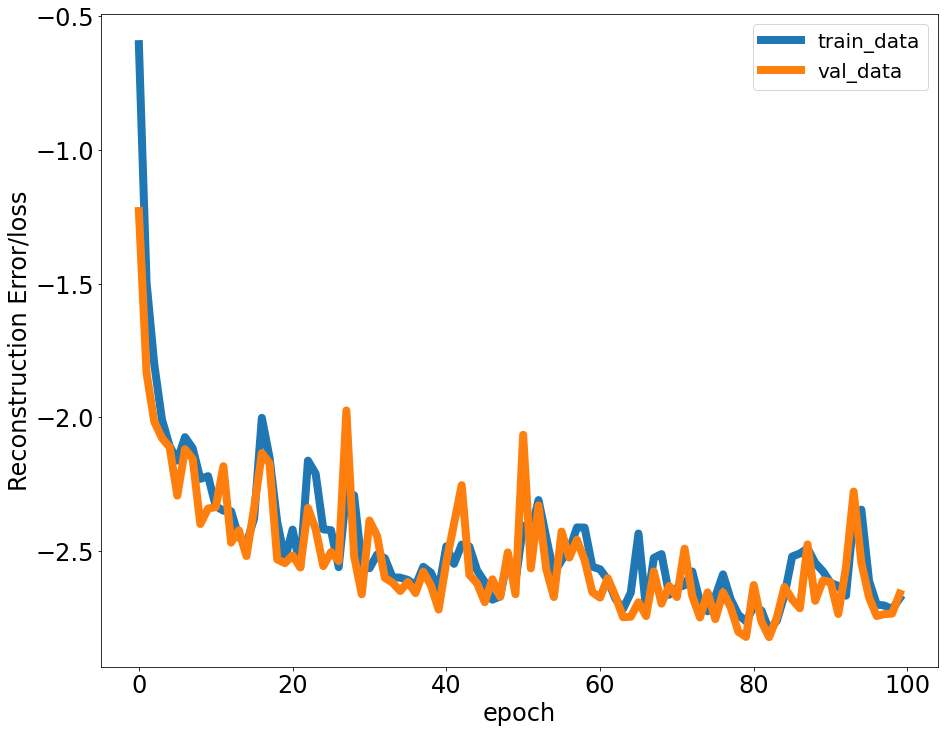

In [ ]:
# loss plot train-validation
import matplotlib as mpl

mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (15,12)
plt.plot(history.history['loss'],linewidth = 8)
plt.plot(history.history['val_loss'],linewidth = 8)
#plt.title('model loss',fontsize = 24)
plt.ylabel('Reconstruction Error/loss',fontsize = 24)
plt.xlabel('epoch',fontsize = 24)
plt.legend(['train_data', 'val_data'], loc='best',fontsize = 20)
plt.show()

In [ ]:
vae.save("VAE_network.h5")

6) Make predictions on test data using model.predict, and visualize your plot comparing benign observations with attack observations. Select the most appropriate threshold value by observing the graph and using trial and error approach. [20% marks].

In [ ]:
from sklearn import metrics

pred1 = vae.predict(x_ben_tr_scaled) # predictions on train normal data
score1 = np.sqrt(metrics.mean_squared_error(pred1,x_ben_tr_scaled))

pred2 = vae.predict(x_ben_tst_scaled) # predictions on test normal data
score2 = np.sqrt(metrics.mean_squared_error(pred2,x_ben_tst_scaled))

pred3 = vae.predict(x_attack_scaled) # predictions on test fraud data
score3 = np.sqrt(metrics.mean_squared_error(pred3,x_attack_scaled))

print(f"Benign_training_data Score (RMSE): {score1}")
print(f"Benign_test_data_score Score (RMSE): {score2}")
print(f"Attack_test_data_score (RMSE): {score3}")

Benign_training_data Score (RMSE): 2.0382317210412917
Benign_test_data_score Score (RMSE): 2.0472932983222654
Attack_test_data_score (RMSE): 3.5640035424841043


In [ ]:
tst_obs = x_ben_tst_scaled.copy() # create a copy of benign data and save in tst_obs
print(tst_obs.shape)
tst_obs = np.append(tst_obs, x_attack_scaled, axis=0) ##combine test benign and test attack data
print(tst_obs.shape)
print(y_benign[0:5747].shape)

(5747, 76)
(11245, 76)
(5747,)


In [ ]:
Y_obs = y_benign[0:5747].copy() # create a copy of normal labels and save in Y_obs
Y_obs  = np.append(Y_obs, y_attack, axis=0)
print(Y_obs.shape)

(11245,)


In [ ]:
test_preds=vae.predict(tst_obs)
mse_test = np.mean(np.power(tst_obs- test_preds, 2), axis=1)

In [ ]:
tst_error_data = pd.DataFrame({'recon_error': mse_test,'Label': Y_obs})

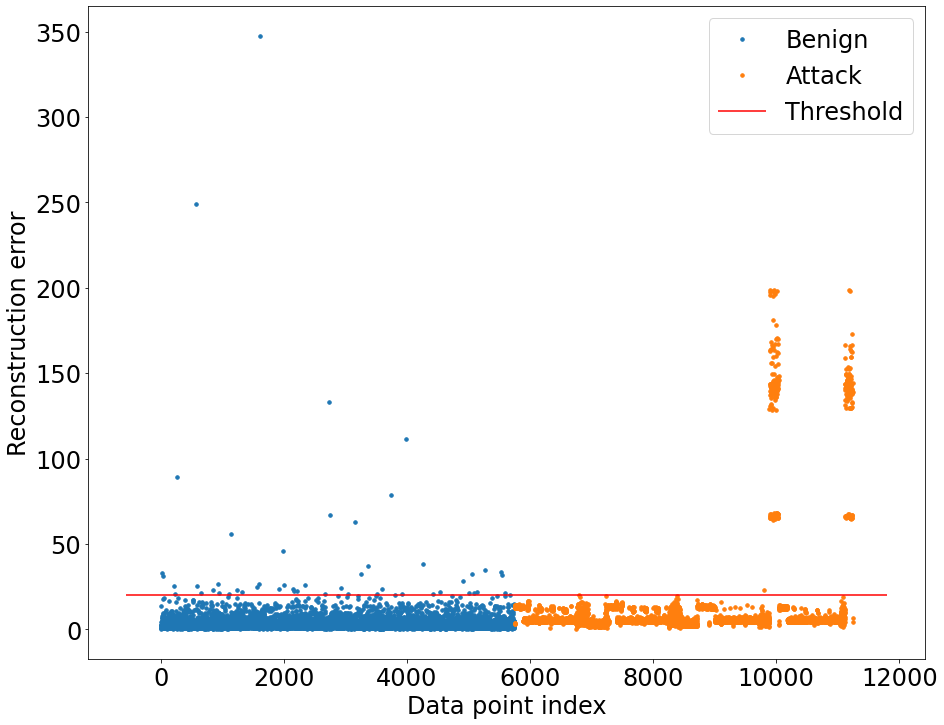

In [ ]:
#####RE for different classes of data
threshold_trial = 20

group1 = tst_error_data.groupby('Label')
fig, ax = plt.subplots()
for name, group in group1:
    ax.plot(group.index, group.recon_error, marker='o', ms=3.5, linestyle='',label= "Attack" if name == 1 else "Benign")
ax.hlines(threshold_trial, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

7) Perform the metric analysis to evaluate the performance of your classifier at your selected threshold. Display the results in terms of TPR, FPR, TNR, FNR, Precision, F1_score and ROC-AUC graph. [15% marks].

In [ ]:
# Compute confusion matrix for test data (fraud+normal)
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)

threshold=20 ##selected using trial and error

y_pred = [1 if e > threshold else 0 for e in tst_error_data.recon_error.values]

cm= confusion_matrix(tst_error_data.Label, y_pred)
print("Confusion matrix:")
print(cm)

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives", tp)
print("Total number of false negatives",fn)
print("Total number of false positives",fp)
print("Total number of true negatives",tn)

acc=float(tp+tn)/(tp+tn+fp+fn)

print('\nClassifier Accuracy: %.2f%%' % (acc * 100))

tpr = float(tp)/(tp+fn)

print('True Positive Rate (TPR/Recall/Sensitivity): %.2f%%' % (tpr * 100))

specificity = float (tn)/(tn+fp)

print ("True Negative Rate (TNR/Specificity/selectivity):%.2f%%" % (specificity*100)) 

fpr = float(fp)/(fp+tn)
print("False Positive Rate (FPR): %.2f%%" % (fpr * 100))

fnr = fn/ (fn+ tp)
print("False Negative Rate (FNR): %.2f%%" % (fnr*100))

precision=float(tp)/(tp+fp)
print("Precision/Positive Predictive value:%.2f%%" %(precision*100))

fscore = 2*((precision*tpr)/(precision+tpr))
print("F1-Score: %.2f%%" %(fscore*100))

Confusion matrix:
[[5695   52]
 [5221  277]]

Total number of true positives 277
Total number of false negatives 5221
Total number of false positives 52
Total number of true negatives 5695

Classifier Accuracy: 53.11%
True Positive Rate (TPR/Recall/Sensitivity): 5.04%
True Negative Rate (TNR/Specificity/selectivity):99.10%
False Positive Rate (FPR): 0.90%
False Negative Rate (FNR): 94.96%
Precision/Positive Predictive value:84.19%
F1-Score: 9.51%


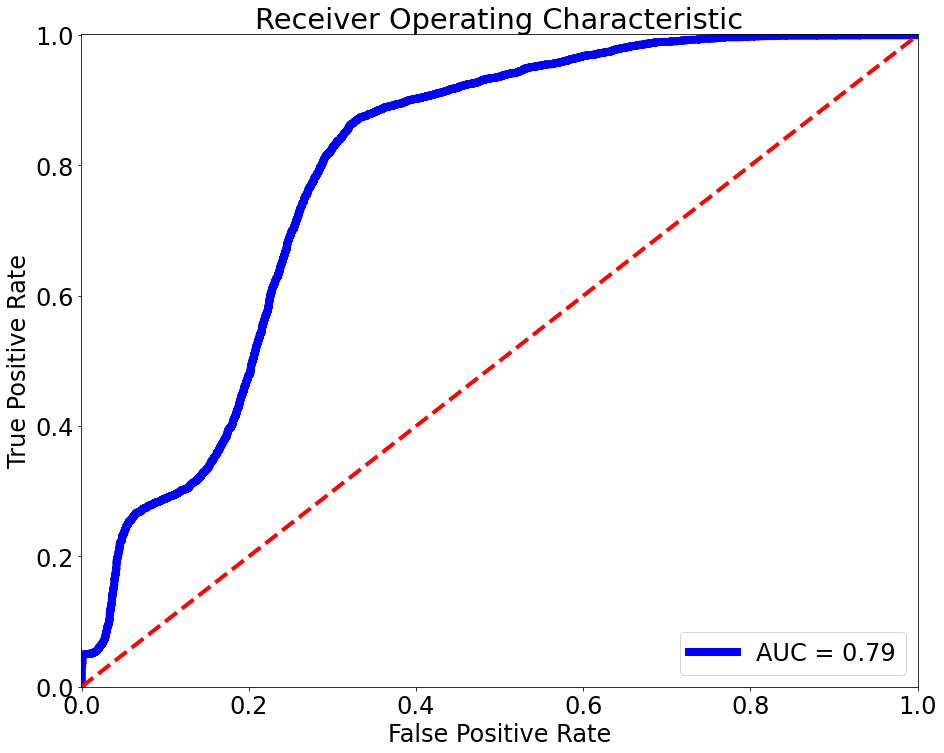

In [ ]:
##########ROC GRAPH#######

fpr, tpr, thresholds = roc_curve(tst_error_data.Label,tst_error_data.recon_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc,linewidth = 8, color='b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--',linewidth = 4)
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()